# AI-based Surveying the Impact of Environmental, Climatic, Economic and Demographic Conditions on the Epidemic Outbreak Rate of COVID-19

$Mehryar{\,}Majd$, $Ramin{\,}Mousa$ \& $Arsalan{\,}Mousazadeh$

__Abstract:__ This study aims to have an analytical and predictive approach to the growth rate and spread of the first wave of COVID-19 infection and mainly focuses on its dependency on other global factors in affected countries via Artificial Intelligence-based processing of fatality data/statistics. Fatality, infected, and recovered cases in the form of the time-series data was acquired through the World Health Organization (WHO) & the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). Recorded health data subsequently was analyzed by several Deep Neural Network (DNN) models to create a better intuition of epidemic outbreak rate of COVID-19. Monitoring spreading trend changes becomes more feasible via continuous observation of statistical pattern and integrating the other datasets with more global features count as factors influencing the local conditions on historical data conveys pivotal information concerning learning the pattern of epidemic progression. In this study, attention-based Sequence-to-Sequence (Seq2Seq) models empowered by Long-Short Term Memory (LSTM) and Gated Recurrent Unit (GRU) units, were deployed to predict mortality rate. Ultimately these analyses are utilized to monitor infection behaviour on time-series data and were subsequently assessed for their performance to predict the behaviour of the first wave of COVID-19 outbreak rate intensely. Demographic & environmental conditions have likely been influenced significantly to shape the reliable predictive learning algorithms for long-duration risk of COVID-19 pandemic.

### Using baseline ML methods on COVID-19 data to analyse and visualize __Confirmed, Deaths & Recovered__ cases
__Data Cleaning & Preprocessing__

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from sklearn.preprocessing import PolynomialFeatures

In [2]:
covid=pd.read_csv("novel-corona-virus/covid_19_data.csv")
covid.head()


,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [3]:
print("Size/Shape of the dataset: ",covid.shape)
print("Checking for null values:\n",covid.isnull().sum())
print("Checking Data-type of each column:\n",covid.dtypes)

Size/Shape of the dataset:  (6162, 8)
Checking for null values:
 SNo                   0
ObservationDate       0
Province/State     2462
Country/Region        0
Last Update           0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64
Checking Data-type of each column:
 SNo                  int64
ObservationDate     object
Province/State      object
Country/Region      object
Last Update         object
Confirmed          float64
Deaths             float64
Recovered          float64
dtype: object


In [4]:
covid.drop(["SNo","Province/State"],1,inplace=True)


In [5]:
#Converting "Observation Date" into Datetime format
covid["ObservationDate"]=pd.to_datetime(covid["ObservationDate"])

In [6]:
#Grouping different types of cases as per the date
datewise=covid.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise.head()


,Confirmed,Recovered,Deaths
ObservationDate,,,
2020-01-22,555.0,28.0,17.0
2020-01-23,653.0,30.0,18.0
2020-01-24,941.0,36.0,26.0
2020-01-25,1438.0,39.0,42.0
2020-01-26,2118.0,52.0,56.0


In [7]:
print("Basic Information")
print("Totol number of countries with Disease Spread: ",len(covid["Country/Region"].unique()))
print("Total number of Confirmed Cases",datewise["Confirmed"].iloc[-1])
print("Total number of Recovered Cases",datewise["Recovered"].iloc[-1])
print("Total number of Deaths Cases",datewise["Deaths"].iloc[-1])

Basic Information
Totol number of countries with Disease Spread:  171
Total number of Confirmed Cases 181546.0
Total number of Recovered Cases 78088.0
Total number of Deaths Cases 7126.0


Text(0.5, 1.0, 'Distribution Plot for Confirmed Cases')

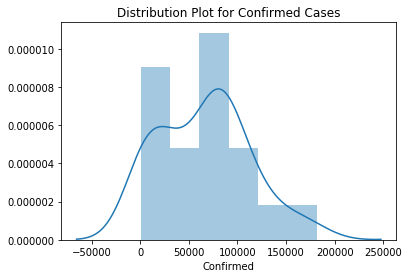

In [8]:
#Distribution plot of confirmed cases around the world 
sns.distplot(datewise["Confirmed"])
plt.title("Distribution Plot for Confirmed Cases")


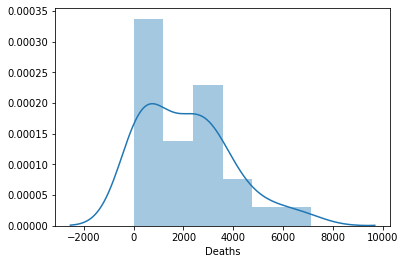

In [9]:
sns.distplot(datewise["Deaths"])

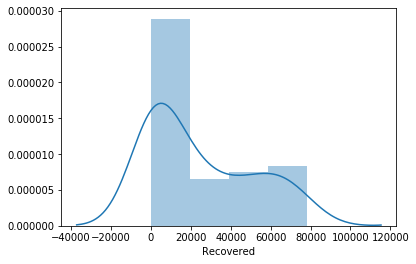

In [10]:
sns.distplot(datewise["Recovered"])

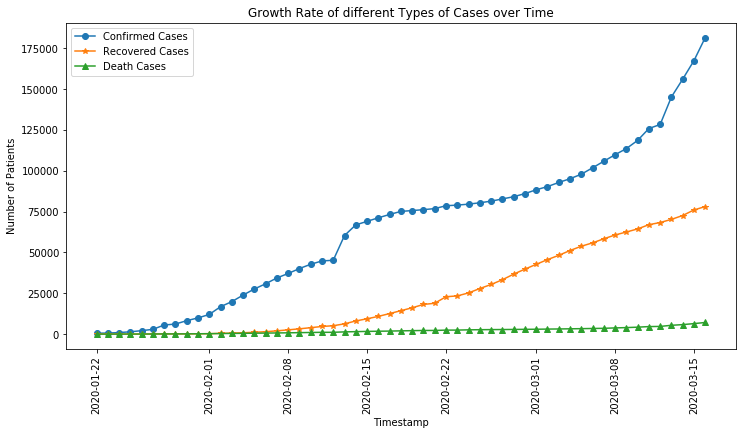

In [11]:
plt.figure(figsize=(12,6))
plt.plot(datewise["Confirmed"],marker="o",label="Confirmed Cases")
plt.plot(datewise["Recovered"],marker="*",label="Recovered Cases")
plt.plot(datewise["Deaths"],marker="^",label="Death Cases")
plt.ylabel("Number of Patients")
plt.xlabel("Timestamp")
plt.xticks(rotation=90)
plt.title("Growth Rate of different Types of Cases over Time")
plt.legend()


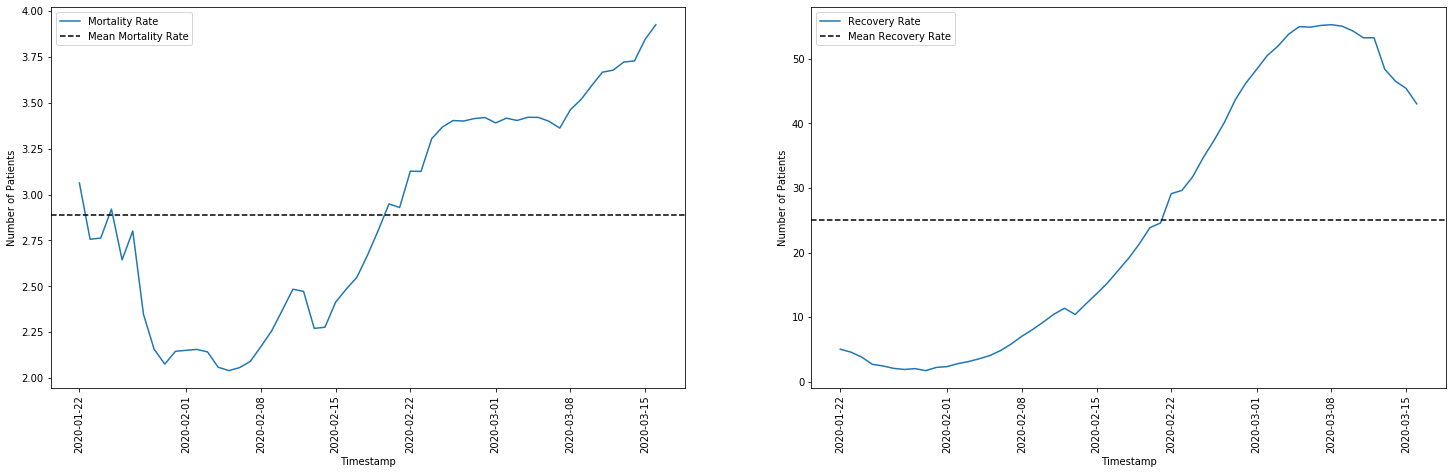

In [12]:
#Calculating the Mortality Rate and Recovery Rate
datewise["Mortality Rate"]=(datewise["Deaths"]/datewise["Confirmed"])*100
datewise["Recovery Rate"]=(datewise["Recovered"]/datewise["Confirmed"])*100

#Plotting Mortality and Recovery Rate 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(25,7))
ax1.plot(datewise["Mortality Rate"],label='Mortality Rate')
ax1.axhline(datewise["Mortality Rate"].mean(),linestyle='--',color='black',label="Mean Mortality Rate")
ax1.set_ylabel("Number of Patients")
ax1.set_xlabel("Timestamp")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax2.plot(datewise["Recovery Rate"],label="Recovery Rate")
ax2.axhline(datewise["Recovery Rate"].mean(),linestyle='--',color='black',label="Mean Recovery Rate")
ax2.set_ylabel("Number of Patients")
ax2.set_xlabel("Timestamp")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

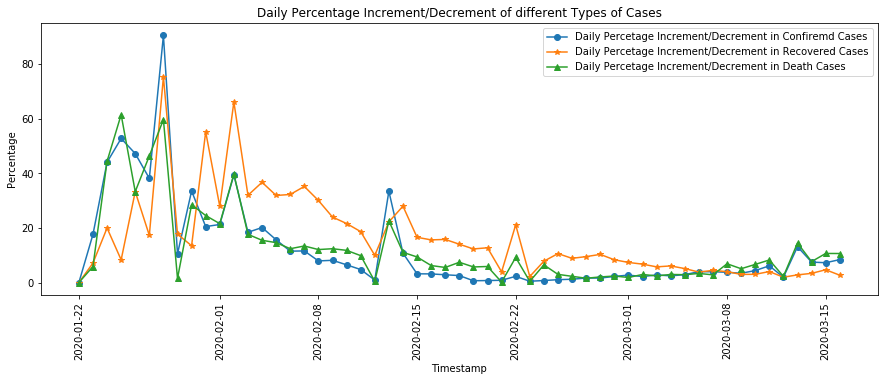

In [13]:
percent_increase_confirm=[]
percent_increase_recovered=[]
percent_increase_deaths=[]
for i in range(datewise.shape[0]-1):
    percent_increase_confirm.append(((datewise["Confirmed"].iloc[i+1]-datewise["Confirmed"].iloc[i])/datewise["Confirmed"].iloc[i])*100)
    percent_increase_recovered.append(((datewise["Recovered"].iloc[i+1]-datewise["Recovered"].iloc[i])/datewise["Recovered"].iloc[i])*100)
    percent_increase_deaths.append(((datewise["Deaths"].iloc[i+1]-datewise["Deaths"].iloc[i])/datewise["Deaths"].iloc[i])*100)
percent_increase_confirm.insert(0,0)
percent_increase_recovered.insert(0,0)
percent_increase_deaths.insert(0,0)

plt.figure(figsize=(15,5))
plt.plot(datewise.index,percent_increase_confirm,label="Daily Percetage Increment/Decrement in Confiremd Cases",marker='o')
plt.plot(datewise.index,percent_increase_recovered,label="Daily Percetage Increment/Decrement in Recovered Cases",marker='*')
plt.plot(datewise.index,percent_increase_deaths,label="Daily Percetage Increment/Decrement in Death Cases",marker='^')
plt.xlabel("Timestamp")
plt.ylabel("Percentage")
plt.title("Daily Percentage Increment/Decrement of different Types of Cases")
plt.xticks(rotation=90)
plt.legend()

In [14]:
#Calculating countrywise Moratality and Recovery Rate
countrywise=covid[covid["ObservationDate"]==covid["ObservationDate"].max()].groupby(["Country/Region"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'}).sort_values(["Confirmed"],ascending=False)
countrywise["Mortality"]=(countrywise["Deaths"]/countrywise["Confirmed"])*100
countrywise["Recovery"]=(countrywise["Recovered"]/countrywise["Confirmed"])*100

Text(0.5, 0, 'Recovery (in Percentage)')

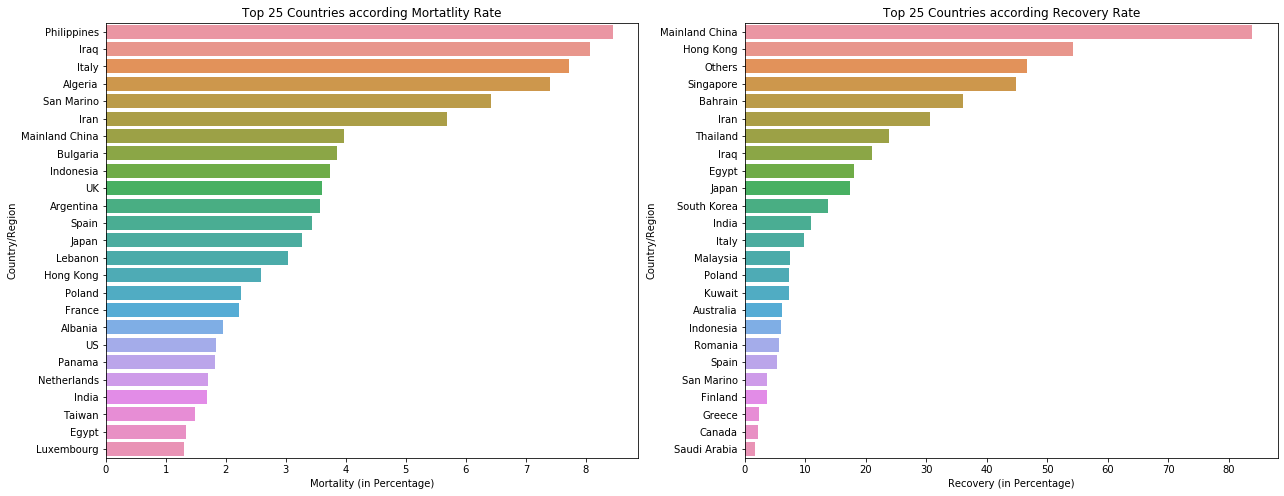

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(21,8))
countrywise_plot_mortal=countrywise[countrywise["Confirmed"]>50].sort_values(["Mortality"],ascending=False).head(25)
sns.barplot(x=countrywise_plot_mortal["Mortality"],y=countrywise_plot_mortal.index,ax=ax1)
ax1.set_title("Top 25 Countries according Mortatlity Rate")
ax1.set_xlabel("Mortality (in Percentage)")
countrywise_plot_recover=countrywise[countrywise["Confirmed"]>100].sort_values(["Recovery"],ascending=False).head(25)
sns.barplot(x=countrywise_plot_recover["Recovery"],y=countrywise_plot_recover.index, ax=ax2)
ax2.set_title("Top 25 Countries according Recovery Rate")
ax2.set_xlabel("Recovery (in Percentage)")


In [16]:
no_recovered_countries=countrywise[(countrywise["Confirmed"]>30)&(countrywise["Recovered"]==0)][["Confirmed","Deaths"]]
no_recovered_countries["Mortality Rate"]=(no_recovered_countries["Deaths"]/no_recovered_countries["Confirmed"])*100
no_recovered_countries[no_recovered_countries["Mortality Rate"]>0].sort_values(["Confirmed"],ascending=False)

,Confirmed,Deaths,Mortality Rate
Country/Region,,,
Slovenia,253.0,1.0,0.395257
Ireland,169.0,2.0,1.183432
Luxembourg,77.0,1.0,1.298701
Panama,55.0,1.0,1.818182
Bulgaria,52.0,2.0,3.846154
Albania,51.0,1.0,1.960784
Ecuador,37.0,2.0,5.405405


In [17]:
china_data=covid[covid["Country/Region"]=="Mainland China"]
Italy_data=covid[covid["Country/Region"]=="Italy"]
Iran_data=covid[covid["Country/Region"]=="Iran"]
rest_of_world=covid[(covid["Country/Region"]!="Mainland China")&(covid["Country/Region"]!="Iran")&(covid["Country/Region"]!="Italy")]

datewise_china=china_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Italy=Italy_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_Iran=Iran_data.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})
datewise_restofworld=rest_of_world.groupby(["ObservationDate"]).agg({"Confirmed":'sum',"Recovered":'sum',"Deaths":'sum'})

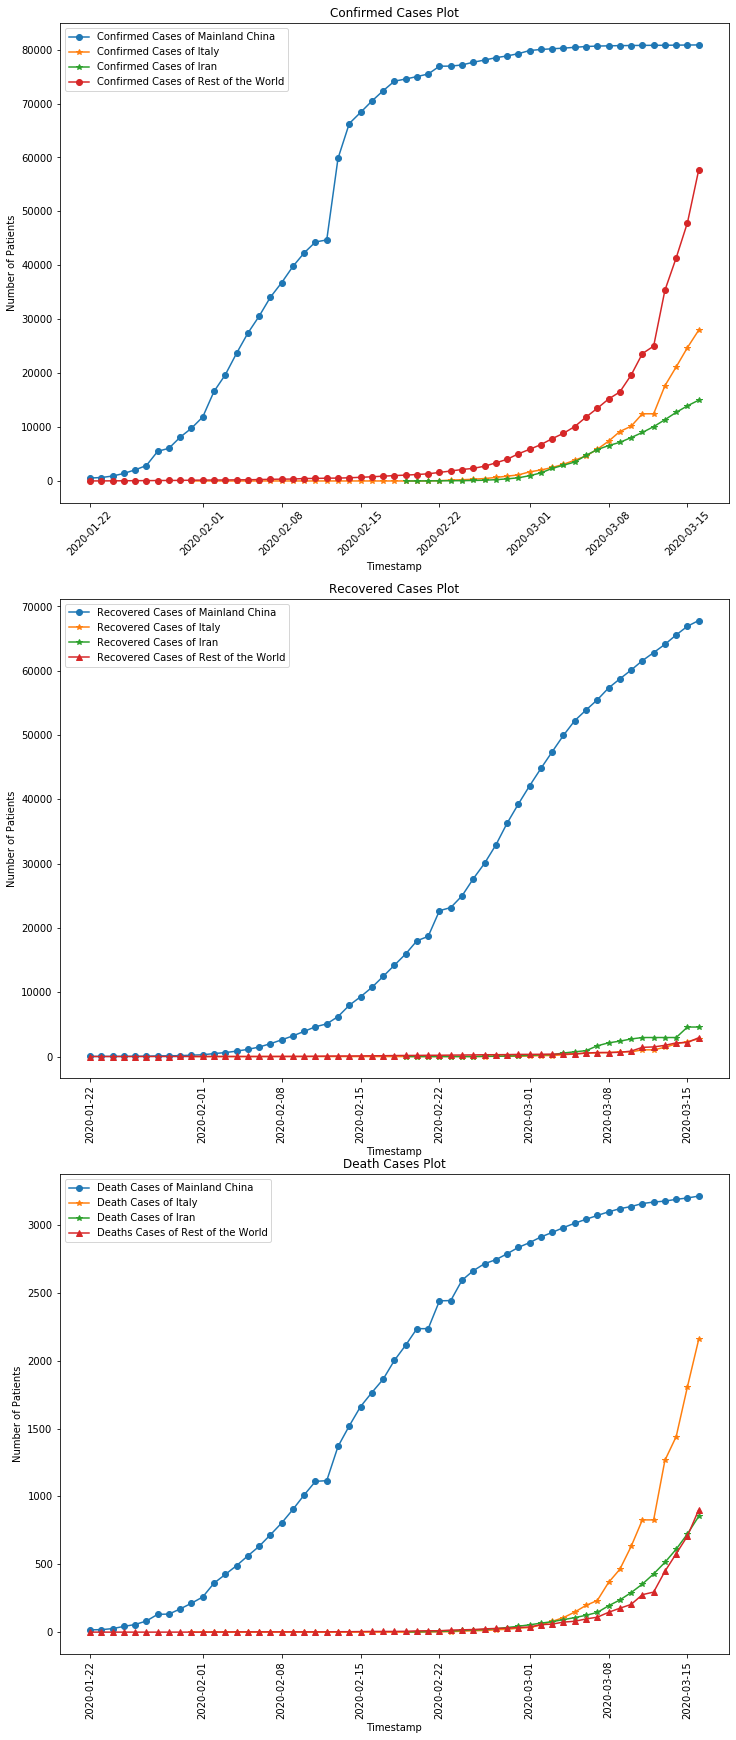

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(12,30))
ax1.plot(datewise_china["Confirmed"],label="Confirmed Cases of Mainland China",marker='o')
ax1.plot(datewise_Italy["Confirmed"],label="Confirmed Cases of Italy",marker='*')
ax1.plot(datewise_Iran["Confirmed"],label="Confirmed Cases of Iran",marker='*')
ax1.plot(datewise_restofworld["Confirmed"],label="Confirmed Cases of Rest of the World",marker='o')
ax1.set_title("Confirmed Cases Plot")
ax1.set_ylabel("Number of Patients")
ax1.set_xlabel("Timestamp")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax2.plot(datewise_china["Recovered"],label="Recovered Cases of Mainland China",marker='o')
ax2.plot(datewise_Italy["Recovered"],label="Recovered Cases of Italy",marker='*')
ax2.plot(datewise_Iran["Recovered"],label="Recovered Cases of Iran",marker='*')

ax2.plot(datewise_restofworld["Recovered"],label="Recovered Cases of Rest of the World",marker='^')
ax2.set_title("Recovered Cases Plot")
ax2.set_ylabel("Number of Patients")
ax2.set_xlabel("Timestamp")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)
ax3.plot(datewise_china["Deaths"],label='Death Cases of Mainland China',marker='o')
ax3.plot(datewise_Italy["Deaths"],label='Death Cases of Italy',marker='*')
ax3.plot(datewise_Iran["Deaths"],label='Death Cases of Iran',marker='*')
ax3.plot(datewise_restofworld["Deaths"],label="Deaths Cases of Rest of the World",marker='^')
ax3.set_title("Death Cases Plot")
ax3.set_ylabel("Number of Patients")
ax3.set_xlabel("Timestamp")
ax3.legend()
for tick in ax3.get_xticklabels():
    tick.set_rotation(90)

In [19]:
datewise_china["Mortality"]=(datewise_china["Deaths"]/datewise_china["Confirmed"])*100
datewise_Italy["Mortality"]=(datewise_Italy["Deaths"]/datewise_Italy["Confirmed"])*100
datewise_Iran["Mortality"]=(datewise_Iran["Deaths"]/datewise_Iran["Confirmed"])*100

datewise_restofworld["Mortality"]=(datewise_restofworld["Deaths"]/datewise_restofworld["Confirmed"])*100
datewise_china["Recovery"]=(datewise_china["Recovered"]/datewise_china["Confirmed"])*100
datewise_Italy["Recovery"]=(datewise_Italy["Recovered"]/datewise_Italy["Confirmed"])*100
datewise_Iran["Recovery"]=(datewise_Iran["Recovered"]/datewise_Iran["Confirmed"])*100
datewise_restofworld["Recovery"]=(datewise_restofworld["Recovered"]/datewise_restofworld["Confirmed"])*100


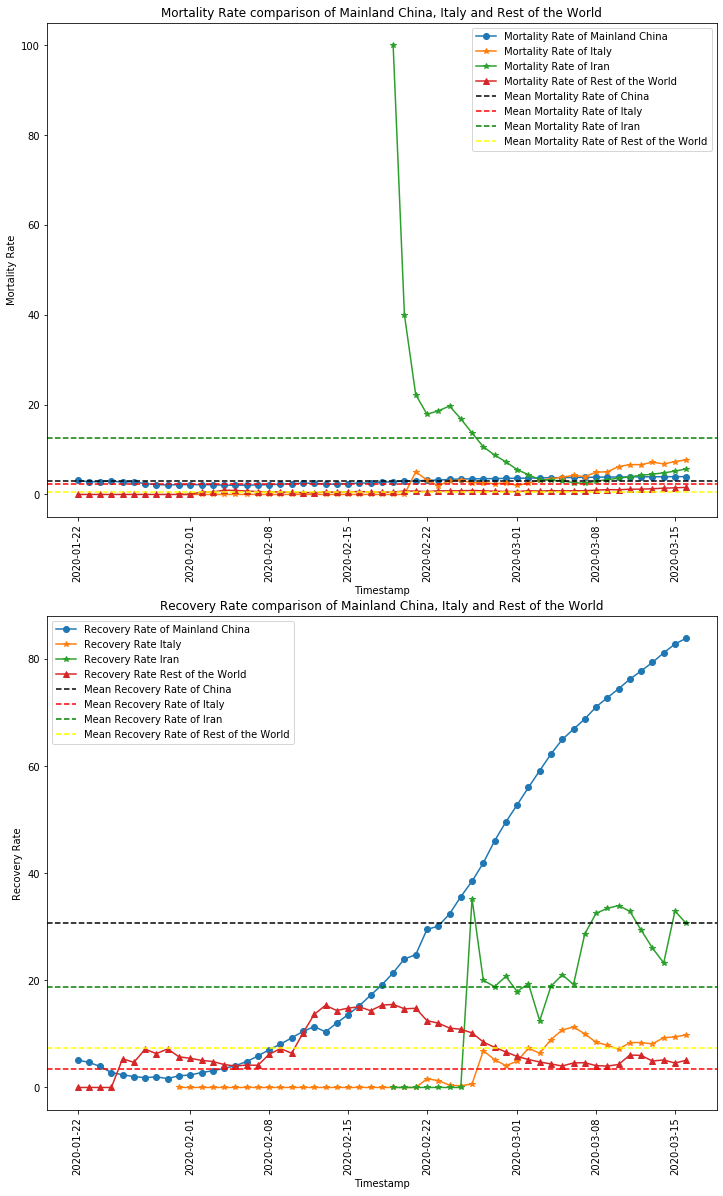

In [20]:
fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(12,20))
ax1.plot(datewise_china["Mortality"],label="Mortality Rate of Mainland China",marker='o')
ax1.plot(datewise_Italy["Mortality"],label="Mortality Rate of Italy",marker='*')
ax1.plot(datewise_Iran["Mortality"],label="Mortality Rate of Iran",marker='*')
ax1.plot(datewise_restofworld["Mortality"],label="Mortality Rate of Rest of the World",marker='^')
ax1.axhline(datewise_china["Mortality"].mean(),linestyle='--',color='black',label="Mean Mortality Rate of China")
ax1.axhline(datewise_Italy["Mortality"].mean(),linestyle='--',color='red',label="Mean Mortality Rate of Italy")
ax1.axhline(datewise_Iran["Mortality"].mean(),linestyle='--',color='green',label="Mean Mortality Rate of Iran")

ax1.axhline(datewise_restofworld["Mortality"].mean(),linestyle='--',color='yellow',label="Mean Mortality Rate of Rest of the World")
ax1.set_ylabel("Mortality Rate")
ax1.set_xlabel("Timestamp")
ax1.set_title("Mortality Rate comparison of Mainland China, Italy and Rest of the World")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(90)
ax2.plot(datewise_china["Recovery"],label="Recovery Rate of Mainland China",marker='o')
ax2.plot(datewise_Italy["Recovery"],label="Recovery Rate Italy",marker='*')
ax2.plot(datewise_Iran["Recovery"],label="Recovery Rate Iran",marker='*')

ax2.plot(datewise_restofworld["Recovery"],label="Recovery Rate Rest of the World",marker='^')
ax2.axhline(datewise_china["Recovery"].mean(),linestyle='--',color='black',label="Mean Recovery Rate of China")
ax2.axhline(datewise_Italy["Recovery"].mean(),linestyle='--',color='red',label="Mean Recovery Rate of Italy")
ax2.axhline(datewise_Iran["Recovery"].mean(),linestyle='--',color='green',label="Mean Recovery Rate of Iran")

ax2.axhline(datewise_restofworld["Recovery"].mean(),linestyle='--',color='yellow',label="Mean Recovery Rate of Rest of the World")
ax2.set_ylabel("Recovery Rate")
ax2.set_xlabel("Timestamp")
ax2.set_title("Recovery Rate comparison of Mainland China, Italy and Rest of the World")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(90)

In [21]:
len(datewise),len(datewise_restofworld),len(datewise_china)

(55, 55, 55)

In [22]:
datewise.head()

,Confirmed,Recovered,Deaths,Mortality Rate,Recovery Rate
ObservationDate,,,,,
2020-01-22,555.0,28.0,17.0,3.063063,5.045045
2020-01-23,653.0,30.0,18.0,2.756508,4.594181
2020-01-24,941.0,36.0,26.0,2.763018,3.825717
2020-01-25,1438.0,39.0,42.0,2.920723,2.712100
2020-01-26,2118.0,52.0,56.0,2.644004,2.455146


# Linear Regression Model for Confirm Cases Prediction¶


In [23]:
datewise["Days Since"]=datewise.index-datewise.index[0]
datewise["Days Since"]=datewise["Days Since"].dt.days
train_ml=datewise.ix['2020-01-22':'2020-03-07']
valid_ml=datewise.ix['2020-03-08':'2020-03-15']


In [25]:
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))
accuracy = lin_reg.score(np.array(valid_ml["Days Since"]).reshape(-1,1),valid_ml["Confirmed"])
print(accuracy*100,'%')

Root Mean Square Value: 18808.28389887525
Mae  Mean Absloud Error:  114.85692342416448
r2_score: 0.07602522557029756
7.602522557029756 %


# RidgeCV

In [26]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
model_ridge = RidgeCV(cv=10)
model_ridge.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=model_ridge.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))
accuracy = model_ridge.score(np.array(valid_ml["Days Since"]).reshape(-1,1),valid_ml["Confirmed"])
print(accuracy*100,'%')

Root Mean Square Value: 18870.168006015785
Mae  Mean Absloud Error:  115.06145692916994
r2_score: 0.06993499196279418
6.9934991962794175 %


/home/rad/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# DecisionTreeRegressor

In [27]:
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor(min_samples_leaf=7,
                               max_depth=8)
model_dt.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=model_dt.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))
accuracy = model_dt.score(np.array(valid_ml["Days Since"]).reshape(-1,1),valid_ml["Confirmed"])
print(accuracy*100,'%')

Root Mean Square Value: 43049.11412071246
Mae  Mean Absloud Error:  195.8197513020584
r2_score: -3.8404998295695965
-384.0499829569596 %


# KNeighborsRegressor

In [28]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
knn = KNeighborsRegressor()
knn.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=knn.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))
accuracy = knn.score(np.array(valid_ml["Days Since"]).reshape(-1,1),valid_ml["Confirmed"])
print(accuracy*100,'%')

Root Mean Square Value: 39593.08086964186
Mae  Mean Absloud Error:  185.52695221988637
r2_score: -3.094495191867898
-309.44951918678976 %


# SVR

In [29]:
from sklearn.svm import SVR
svr= SVR(kernel='rbf',gamma=10,C=1.0, epsilon=0.05)
svr.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=svr.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))
accuracy = svr.score(np.array(valid_ml["Days Since"]).reshape(-1,1),valid_ml["Confirmed"])
print(accuracy*100,'%')

Root Mean Square Value: 72191.9926115463
Mae  Mean Absloud Error:  263.6090855686219
r2_score: -12.612560717328837
-1261.2560717328836 %


`China prediciton`


In [30]:
datewise_china["Days Since"]=datewise_china.index-datewise_china.index[0]
datewise_china["Days Since"]=datewise_china["Days Since"].dt.days
train_ml=datewise_china.ix['2020-01-22':'2020-03-07']
valid_ml=datewise_china.ix['2020-03-08':'2020-03-15']


# LinearRegression

In [31]:
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 28231.873663591847
Mae  Mean Absloud Error:  166.66234144094787
r2_score: -384580.2784750239


# RidgeCV

In [32]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
model_ridge = RidgeCV(cv=10)
model_ridge.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=model_ridge.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 28157.969900260334
Mae  Mean Absloud Error:  166.44026242147143
r2_score: -382569.4446644945


/home/rad/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# DecisionTreeRegressor

In [33]:
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor(min_samples_leaf=7,
                               max_depth=8)
model_dt.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=model_dt.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 932.3371090973537
Mae  Mean Absloud Error:  30.515979420624955
r2_score: -418.4253503117537


# KNeighborsRegressor

In [34]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
knn = KNeighborsRegressor()
knn.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=knn.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 369.63910101610986
Mae  Mean Absloud Error:  19.15267605323071
r2_score: -64.92718702643916


# SVR

In [35]:
from sklearn.svm import SVR
svr= SVR(kernel='rbf',gamma=10,C=1.0, epsilon=0.05)
svr.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=svr.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 17718.68347747146
Mae  Mean Absloud Error:  133.111325567455
r2_score: -151484.69898135908


`Italy`

In [36]:
datewise_Italy["Days Since"]=datewise_Italy.index-datewise_Italy.index[0]
datewise_Italy["Days Since"]=datewise_Italy["Days Since"].dt.days
train_ml=datewise_Italy.ix['2020-01-22':'2020-03-07']
valid_ml=datewise_Italy.ix['2020-03-08':'2020-03-15']

# LinearRegression

In [37]:
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 12736.31292741243
Mae  Mean Absloud Error:  107.07357781850914
r2_score: -3.885763912850706


# RidgeCV

In [38]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
model_ridge = RidgeCV(cv=10) 
model_ridge.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=model_ridge.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 12741.18699343023
Mae  Mean Absloud Error:  107.09771343481886
r2_score: -3.889504099292637


/home/rad/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# DecisionTreeRegressor

In [39]:
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor(min_samples_leaf=7,
                               max_depth=8)
model_dt.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=model_dt.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 12428.918696708404
Mae  Mean Absloud Error:  104.94079963756435
r2_score: -3.652771553243924


# KNeighborsRegressor

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
knn = KNeighborsRegressor()
knn.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=knn.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 11893.394379234214
Mae  Mean Absloud Error:  102.00196076546764
r2_score: -3.2604617992183167


# SVR

In [41]:
from sklearn.svm import SVR
svr= SVR(kernel='rbf',gamma=10,C=1.0, epsilon=0.05)
svr.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=svr.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 15504.753044756579
Mae  Mean Absloud Error:  119.97627716753722
r2_score: -6.240603101824865


`Iran`

In [42]:
datewise_Iran["Days Since"]=datewise_Iran.index-datewise_Iran.index[0]
datewise_Iran["Days Since"]=datewise_Iran["Days Since"].dt.days
train_ml=datewise_Iran.ix['2020-01-22':'2020-03-07']
valid_ml=datewise_Iran.ix['2020-03-08':'2020-03-15']

# LinearRegression

In [43]:
lin_reg=LinearRegression(normalize=True)
lin_reg.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=lin_reg.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 5083.459409353002
Mae  Mean Absloud Error:  68.90065193161315
r2_score: -3.189172118948024


# RidgeCV

In [44]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
model_ridge = RidgeCV(cv=10) 
model_ridge.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=model_ridge.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 5084.242616181328
Mae  Mean Absloud Error:  68.90635715289925
r2_score: -3.190463066979561


/home/rad/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# DecisionTreeRegressor

In [45]:
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor(min_samples_leaf=7,
                               max_depth=8)
model_dt.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=model_dt.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 7185.147858781406
Mae  Mean Absloud Error:  82.11109634426484
r2_score: -7.36914136043403


# KNeighborsRegressor

In [46]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
knn = KNeighborsRegressor()
knn.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=knn.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 6485.586586038305
Mae  Mean Absloud Error:  77.40268083212622
r2_score: -5.81880086698694


# SVR

In [47]:
from sklearn.svm import SVR
svr= SVR(kernel='rbf',gamma=10,C=1.0, epsilon=0.05)
svr.fit(np.array(train_ml["Days Since"]).reshape(-1,1),np.array(train_ml["Confirmed"]).reshape(-1,1))
prediction_valid_linreg=svr.predict(np.array(valid_ml["Days Since"]).reshape(-1,1))
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Root Mean Square Value:",np.sqrt(mean_squared_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("Mae  Mean Absloud Error: ",np.sqrt(mean_absolute_error(valid_ml["Confirmed"],prediction_valid_linreg)))
print("r2_score: {}".format(r2_score(valid_ml["Confirmed"],prediction_valid_linreg)))

Root Mean Square Value: 9860.786919869442
Mae  Mean Absloud Error:  97.68763992606745
r2_score: -14.762773415594634
